In [38]:
from word_embedding.test.core.load_embeddings import load_pretrained_glove, load_pretrained_w2v, normalize_cols_numexpr, load_w2v
from word_embedding.test.core.measures import center_and_normalize_riemannian
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from itertools import islice
from word_embedding.test.core.clustering.utils import load_csv_into_dict, get_indices, preprocess_clusters, purity_score, silhouette
from functools import partial

0.9725219957734033 -4.524941615775392 0.3925777761729583 -0.20708426308858172
2.0436460175048707 -3.6667523245700258 2.980184627897331 -3.1185886972602503


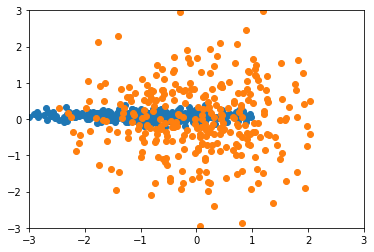

In [39]:
# random 2D points
import matplotlib.pyplot as plt
import sklearn
# data = np.random.uniform(0, 1, (300, 2)) * np.array([0.1, 7])
plt.xlim(-3,3)
plt.ylim(-3,3)

data = np.random.normal(size=(300, 2)) * np.array([1, 0.1]) + np.array([-1, 0.1])
x, y = zip(*data)
plt.scatter(x, y)
print(np.max(x), np.min(x), np.max(y), np.min(y))

data = sklearn.preprocessing.scale(data)
x, y = zip(*data)
plt.scatter(x, y)
print(np.max(x), np.min(x), np.max(y), np.min(y))


In [40]:
# dictionary, vecs = load_pretrained_glove("commoncrawl42B") # "commoncrawl840B"
# dictionary, vecs = load_pretrained_glove("wikigiga5")
# dictionary, vecs = load_pretrained_w2v("googlenews")

dictionary, vecs = load_w2v("/data2/text/word_embeddings/word2vec/geb/word2vec-cbow-geb-m01000-v300-sw10-ns10-lr0.05-n50/word2vec-cbow-geb-m01000-v300-sw10-ns10-lr0.05-n50-vectors.txt", 300)

orig_embeddings = vecs['u'] + vecs['v']


In [41]:
vecs['v'].shape

(66193, 300)

In [42]:
from sklearn.cluster import KMeans, AffinityPropagation

In [43]:
# groups_filename = "/data/captamerica_hd2/text/concept_categorization_datasets/ap.csv"
groups_filename = "/data/captamerica_hd2/text/concept_categorization_datasets/battig.csv"
# groups_filename = "/data/captamerica_hd2/text/concept_categorization_datasets/capitals.csv"
groups = load_csv_into_dict(groups_filename, dictionary)

words in_dict/total: 72.93% (3815/5231)


In [44]:
ngroups = len(groups)
print(ngroups)

56


In [45]:
# embeddings = normalize_cols_numexpr(orig_embeddings-np.mean(orig_embeddings, axis=0))
# embeddings = center_and_normalize_riemannian(orig_embeddings, np.eye(orig_embeddings.shape[1]))
# embeddings = orig_embeddings/np.linalg.norm(orig_embeddings, axis=1).reshape(-1, 1)
embeddings = orig_embeddings

In [46]:
embeddings.shape

(66193, 300)

In [47]:
clusters = {g:embeddings[get_indices(dictionary, words)] for g, words in groups.items()}

In [48]:
# # PREPROCESSING
# clusters = preprocess_clusters(clusters)

In [49]:
points_list, labels_list = zip(*[(clusters[g], [i]*clusters[g].shape[0]) for i,g in enumerate(clusters.keys())])

clusters_points = np.concatenate(points_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

In [50]:
clusters_points.shape

(3815, 300)

In [51]:
perm = np.random.permutation(clusters_points.shape[0])
shuffled_clusters_points = clusters_points[perm]
shuffled_labels = labels[perm]

In [52]:
def print_scores(labels, predictions, clusters_points, dist_method):
    distances = dist_method(clusters_points, clusters_points)
    print(purity_score(labels, predictions),
          metrics.homogeneity_score(labels, predictions),
          metrics.completeness_score(labels, predictions),
          sklearn.metrics.silhouette_score(distances, predictions, metric="precomputed")
          )

In [53]:
import importlib
import word_embedding
importlib.reload(word_embedding)
import word_embedding.test.core.clustering.KMeansSim
importlib.reload(word_embedding.test.core.clustering.KMeansSim)
import word_embedding.test.core.clustering.RepeatedBisectionSim
importlib.reload(word_embedding.test.core.clustering.RepeatedBisectionSim)
import word_embedding.test.core.clustering.utils
importlib.reload(word_embedding.test.core.clustering.utils)

from word_embedding.test.core.clustering.KMeansSim import KMeansSim
from word_embedding.test.core.clustering.RepeatedBisectionSim import RepeatedBisectionSim

from word_embedding.test.core.clustering.utils import cos_similarity, dist_on_sphere, riemannian_dist

Id = np.eye(clusters_points.shape[1])

N_INIT = 100
TOL = 1e-10
MAX_ITER = 1000

In [54]:
silhouette(clusters_points, labels, partial(dist_on_sphere, g_matrix=Id))

0.0018793642786831036

In [55]:
kmeans = KMeans(n_clusters=ngroups, n_init=N_INIT, tol=TOL)
kmeans.fit(shuffled_clusters_points)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=56, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=0)

In [56]:
print_scores(shuffled_labels, kmeans.labels_, shuffled_clusters_points, partial(dist_on_sphere, g_matrix=Id))

0.49882044560943645 0.5620037640825458 0.5561738932548305 0.06055433362181918


In [57]:
kmeancos = KMeansSim(n_clusters=ngroups, g_matrix=Id, n_init=N_INIT)
kmeancos.fit(shuffled_clusters_points)


In [58]:
print_scores(shuffled_labels, kmeancos.labels_, shuffled_clusters_points, partial(dist_on_sphere, g_matrix=Id))

0.4925294888597641 0.5588333612044702 0.5506290140660947 0.06628822026925724


In [59]:
bisection_metric = 'agg'
# bisection_metric = 'size'

krbcos = RepeatedBisectionSim(n_clusters=ngroups, g_matrix=Id, n_init=N_INIT, bm=bisection_metric)
krbcos.fit(shuffled_clusters_points)


In [60]:
print_scores(shuffled_labels, krbcos.labels_, shuffled_clusters_points, partial(dist_on_sphere, g_matrix=Id))

0.5187418086500656 0.5697950861677299 0.553656279610123 0.06207970269030817


In [61]:
from spherecluster import SphericalKMeans

skm = SphericalKMeans(n_clusters=ngroups, n_init=N_INIT, tol=TOL, max_iter=MAX_ITER)
skm.fit(shuffled_clusters_points)


SphericalKMeans(copy_x=True, init='k-means++', max_iter=1000, n_clusters=56,
                n_init=100, n_jobs=1, normalize=True, random_state=None,
                tol=1e-10, verbose=0)

In [62]:
print_scores(shuffled_labels, skm.labels_, shuffled_clusters_points, partial(dist_on_sphere, g_matrix=Id))

0.5355176933158584 0.5821135539594028 0.5680836641754545 0.06871950210682501


In [ ]:
# movMF-soft
from spherecluster import VonMisesFisherMixture
vmf_soft = VonMisesFisherMixture(n_clusters=ngroups, n_init=N_INIT, posterior_type='soft', tol=TOL)
vmf_soft.fit(shuffled_clusters_points)


In [ ]:
print_scores(shuffled_labels, vmf_soft.labels_, shuffled_clusters_points, partial(dist_on_sphere, g_matrix=Id))

In [ ]:
# movMF-hard
from spherecluster import VonMisesFisherMixture
vmf_hard = VonMisesFisherMixture(n_clusters=ngroups, n_init=N_INIT, posterior_type='hard', tol=TOL)
vmf_hard.fit(shuffled_clusters_points)

In [ ]:
print_scores(shuffled_labels, vmf_hard.labels_, shuffled_clusters_points, partial(dist_on_sphere, g_matrix=Id))

In [ ]:
logreg = sklearn.linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='multinomial')
logreg.fit(shuffled_clusters_points, shuffled_labels)


In [ ]:
predictions = logreg.predict(clusters_points)


In [ ]:
print_scores(labels, predictions, clusters_points, partial(dist_on_sphere, g_matrix=Id))

In [51]:
# from sklearn.decomposition import uniform# N_COMPONENTS = 2
# pca = PCA(n_components=N_COMPONENTS)
# cp_2d = pca.fit_transform(shuffled_clusters_points)

# print(cp_2d.shape)

# from matplotlib import pyplot as plt

# colors = ['r', 'b']
# markers = ['o', 'x']

# cs = [colors[l] for l in shuffled_labels]
# ms = [markers[l] for l in kmeans.labels_]
# x, y = zip(*cp_2d)

# for i in range(len(cs)):
#     plt.scatter(x[i], y[i], marker=ms[i], color=cs[i])

